# State Estimation for NMC Battery Data
This notebook demonstrates the process of state estimation from battery data collected from the [CAMP Facility](https://www.anl.gov/cse/cell-analysis-modeling-and-prototyping-camp-facility) and published at the [Materials Data Facility](https://doi.org/10.18126/fdxq-7yul).

In [71]:
%matplotlib inline
from moirae.estimators.online.joint import JointEstimator
from moirae.estimators.offline.loss import MeanSquaredLoss
from moirae.estimators.offline.scipy import ScipyMinimizer, ScipyDifferentialEvolution
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.components.soc import SOCInterpolatedHealth
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity
from moirae.simulator import Simulator
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput, ECMMeasurement
from moirae.interface import run_online_estimate
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from battdat.data import CellDataset
from shutil import copyfileobj
from pathlib import Path
import numpy as np
import requests

Configuration

In [72]:
data_url = 'https://data.materialsdatafacility.org/mdf_open/camp_2023/1.1//hdf5/refined/batch_B10A_cell_3.h5'
num_soc_steps: int = 9  # Number of interpolation steps in the OCV measurements
data_dir = Path('data')

In [73]:
data_dir.mkdir(exist_ok=True)

## Download and Parse the Data
Download the data using HTTP and store locally

In [74]:
data_path = data_dir / data_url.split("/")[-1]
print(f'Saving data to {data_path}')

Saving data to data/batch_B10A_cell_3.h5


Download if not present

In [75]:
if not data_path.exists():
    with data_path.open('wb') as fp:
        copyfileobj(requests.get(data_url, stream=True).raw, fp)

In [76]:
dataset = CellDataset.from_hdf(data_path)

In [77]:
dataset.metadata.model_dump(exclude_defaults=True)

{'name': 'CAMP_batch_B10A_cell_3',
 'version': '0.4.0',
 'battery': {'layer_count': 2,
  'anode': {'name': 'C',
   'supplier': 'Commercial',
   'product': 'Graphite',
   'thickness': 92.0,
   'loading': 6.75,
   'porosity': 32.2},
  'cathode': {'name': 'NMC532',
   'supplier': 'Commercial',
   'thickness': 94.0,
   'area': 785.1199999999999,
   'loading': 12.7,
   'porosity': 33.8},
  'electrolyte': {'name': 'Gen 2'},
  'nominal_capacity': 1.5},
 'dataset_name': 'camp_2023',
 'authors': [('Logan', 'Ward'),
  ('Joseph', 'Kubal'),
  ('Susan J.', 'Babinec'),
  ('Wenquan', 'Lu'),
  ('Allison', 'Dunlop'),
  ('Steve', 'Trask'),
  ('Andrew', 'Jansen'),
  ('Noah H.', 'Paulson')],
 'associated_ids': [AnyUrl('https://doi.org/10.1016/j.jpowsour.2022.231127')]}

## Get Initial Parameter Estimates for Equivalent Circuit Parameters
Let's start with some educated guesses for the parameters. 

First up, make a model for the open circuit voltage using a regular cycle

In [78]:
initial_cycles = dataset.tables['raw_data'].query('816 < cycle_number < 840')  # Get cycles after some initial tests

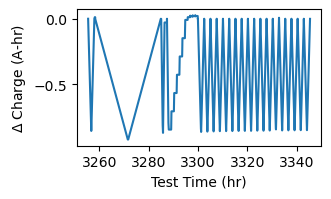

In [79]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, -initial_cycles['cycle_capacity'])

ax.set_xlabel('Test Time (hr)')
ax.set_ylabel('$\Delta$ Charge (A-hr)')
fig.tight_layout()

Estimate a capacity by getting the maximum amount of energy added to the battery

In [80]:
cycle_capacities = initial_cycles.groupby('cycle_number')['cycle_capacity'].max()
cycle_capacities.describe()

count    23.000000
mean      0.823703
std       0.180185
min       0.000000
25%       0.854375
50%       0.858214
75%       0.860809
max       0.924829
Name: cycle_capacity, dtype: float64

In [81]:
initial_capacity = cycle_capacities.median()
print(f'Initial capacity estimate is {initial_capacity:.2f} A-hr')

Initial capacity estimate is 0.86 A-hr


Estimate the Open Circuit Voltage by measuring the voltage at different states of charge during both charge and discharge

In [82]:
discharging = initial_cycles.query('state == b"discharging"')
charging = initial_cycles.query('state == b"charging"')

In [83]:
def get_voltage_measurments(subset):
    """Determine measurements at different SOCs"""

    voltage_steps = np.zeros((len(set(subset['cycle_number'])), num_soc_steps))
    for i, (_, group) in enumerate(subset.groupby('cycle_number')):
        group = group.sort_values('cycle_capacity')
        f = interp1d(group['cycle_capacity'], group['voltage'])
        steps = np.linspace(
            group['cycle_capacity'].min(), 
            group['cycle_capacity'].max(),
            num_soc_steps
        )
        voltage_steps[i, :] = f(steps)
    return voltage_steps.mean(axis=0)

In [84]:
discharge_volt = get_voltage_measurments(discharging)
charge_volt = get_voltage_measurments(charging)
ocv = 0.5 * (discharge_volt + charge_volt)

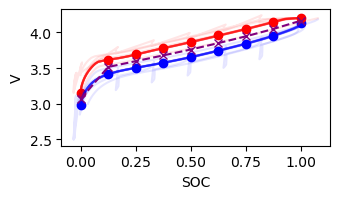

In [85]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

soc_values = np.linspace(0, 1, num_soc_steps)
for subset, points, color in [(discharging, discharge_volt, 'blue'), (charging, charge_volt, 'red')]:
    for gid, group in subset.groupby('cycle_number'):
        ax.plot(group['cycle_capacity'] / initial_capacity, group['voltage'], alpha=0.1, color=color)
    ax.scatter(soc_values, points, marker='o', color=color)
ax.plot(soc_values, ocv, '--x', color='purple')

ax.set_xlabel('SOC')
ax.set_ylabel('V')
fig.tight_layout()

Estimate a SOC-dependent series resistance based on the difference in voltage between charge and discharge and the charge difference

$V_c - V_d = OCV + I_c R - (OCV - I_d R) = (I_c + I_d)R$

In [86]:
charge_current = charging['current'].abs().mean()
discharge_current = discharging['current'].abs().mean()
print(f'Charge current {charge_current:.1f} A. Discharge current {discharge_current:.1f} A')

Charge current 0.9 A. Discharge current 1.0 A


In [87]:
r_serial = (charge_volt - discharge_volt) / (discharge_current + charge_current)

## Create a ECM Model
Models in Moirae require definine the parameters of the system as type of `HealthVariable` class which corresponds to a certain `CellModel`.

In [88]:
asoh = ECMASOH(
    q_t=MaxTheoreticalCapacity(base_values=initial_capacity),
    r0=Resistance(base_values=r_serial),
    ocv=OpenCircuitVoltage(
        ocv_ref=SOCInterpolatedHealth(base_values=ocv),
        ocv_ent={'base_values': 0}
    )
)

The transient state of the battery system (e.g., its state of charge) is represented by a `ECMTransientVector` class.

In [89]:
ecm_start = ECMTransientVector(soc=0.)

Let's simulate a cycle then show it's pretty similar to supplied data. It will also need to now the starting inputs applied to the circuit (rest at 25C at the time at the beginning of the test).

In [90]:
simulator = Simulator(
    cell_model=ECM(),
    asoh=asoh,
    transient_state=ecm_start,
    initial_input=ECMInput(time=initial_cycles.test_time.min(), current=0, temperature=25)
)

In [91]:
%%time
sim_voltages = np.zeros((len(initial_cycles),))
sim_soc = np.zeros((len(initial_cycles),))
for j, (t, i) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'])):
    state, outputs = simulator.step(ECMInput(time=t, current=i, temperature=25.))  # Moirae 
    sim_voltages[j] = outputs.terminal_voltage.item()  # terminal voltage is a (1, 1) array
    sim_soc[j] = state.soc.item()

CPU times: user 1.15 s, sys: 1.87 ms, total: 1.15 s
Wall time: 1.15 s


Text(0, 0.5, 'Voltage')

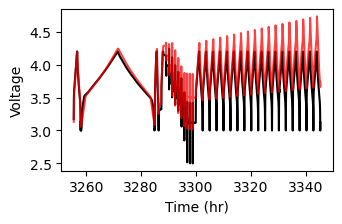

In [92]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, sim_voltages, 'r', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

The simulator recreates the observed voltage decently but diverges from observations over time. Online parameter estimation will ensure the simulated physics model stays more consistant.

## Refine Estimates Using Scipy Optimizer
Our initial guesses are defined using simple rules, and we can do better by fitting them to the available data.

The first step is to define a loss function, which requires:
- The physics models
- A guess for the initial transient state
- A guess for the ASOH parameters
- The data used to estimate parameters

In [93]:
for p in ['r0.base_values']:
    asoh.mark_updatable(p) 
print(f'Made {asoh.num_updatable} parameters updatable')

Made 9 parameters updatable


In [95]:
loss = MeanSquaredLoss(
    cell_model=ECM(),
    transient_state=ecm_start,
    asoh=asoh,
    observations=CellDataset(raw_data=initial_cycles)
)

Then define the optimizer. We'll use Scipy's minimize function using the Nedler-Mead optimizer, a optimizer that completes iterations quickly.

> WARNING: We use only 4 iterations because too much fitting leads to overfitting to these limited cycles. The solution to this issue is something we're still pondering.

In [96]:
%%time
opt = ScipyMinimizer(loss, method='Nelder-Mead', options=dict(maxiter=4))
fit_state, fit_asoh, result = opt.estimate()
result

CPU times: user 22 s, sys: 26.2 ms, total: 22 s
Wall time: 22 s


       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.9926909979268616
             x: [ 6.818e-05  6.818e-05  9.510e-02  1.118e-01  1.029e-01
                  1.129e-01  1.150e-01  1.153e-01  1.126e-01  9.287e-02
                  3.825e-02]
           nit: 4
          nfev: 16
 final_simplex: (array([[ 6.818e-05,  6.818e-05, ...,  9.287e-02,
                         3.825e-02],
                       [-2.376e-04,  5.785e-05, ...,  1.013e-01,
                         3.817e-02],
                       ...,
                       [ 0.000e+00,  0.000e+00, ...,  1.032e-01,
                         3.773e-02],
                       [ 0.000e+00,  0.000e+00, ...,  1.032e-01,
                         3.773e-02]]), array([ 9.927e-01,  9.967e-01,  9.974e-01,  9.976e-01,
                        9.999e-01,  1.000e+00,  1.000e+00,  1.000e+00,
                        1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00]))

Plot the changes

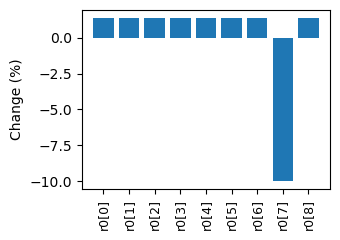

In [97]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

change = 100 * (np.divide(fit_asoh.get_parameters(), asoh.get_parameters())[0, :] - 1)
x = np.arange(len(change))
ax.bar(x, change)

ax.set_ylabel('Change (%)')
ax.set_xticks(x)
ax.set_xticklabels(
    [x.replace('.base_values', '').replace('ocv_ref', '') for x in asoh.expand_names(asoh.updatable_names)],
    fontsize=9,
    rotation='vertical'
)
fig.tight_layout()

Show the changes on the predicted cycle life

In [101]:
simulator = Simulator(
    cell_model=ECM(),
    asoh=fit_asoh,
    transient_state=fit_state,
    initial_input=ECMInput(time=initial_cycles.test_time.min(), current=0, temperature=25)
)

In [102]:
%%time
fit_sim_voltages = np.zeros((len(initial_cycles),))
fit_sim_soc = np.zeros((len(initial_cycles),))
for j, (t, i) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'])):
    state, outputs = simulator.step(ECMInput(time=t, current=i, temperature=25.))  # Moirae 
    fit_sim_voltages[j] = outputs.terminal_voltage.item()  # terminal voltage is a (1, 1) array
    fit_sim_soc[j] = state.soc.item()

CPU times: user 1.12 s, sys: 2.01 ms, total: 1.12 s
Wall time: 1.12 s


In [103]:
fit_state

ECMTransientVector(soc=array([[6.81818182e-05]]), q0=None, i_rc=array([], shape=(1, 0), dtype=float64), hyst=array([[6.81818182e-05]]))

Text(0, 0.5, 'Voltage')

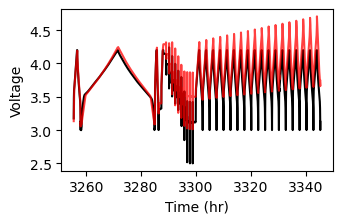

In [104]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, fit_sim_voltages, 'r', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

## Use Global Optimizer as Comparsion
This time, let's try using a global optimizer and see if we get a better fitting result

In [108]:
%%time
# estimate crude bounds for the optimization based on the previously optimized parameters
bounds = np.zeros((result.x.size, 2))
bounds[:, 1] = 5 * result.x
opt = ScipyDifferentialEvolution(loss, bounds=bounds, maxiter=1)
fit_state, fit_asoh, result = opt.estimate()
result

ValueError: Some entries in x0 lay outside the specified bounds

In [109]:
simulator = Simulator(
    cell_model=ECM(),
    asoh=fit_asoh,
    transient_state=fit_state,
    initial_input=ECMInput(time=initial_cycles.test_time.min(), current=0, temperature=25)
)

In [110]:
%%time
fit_sim_voltages = np.zeros((len(initial_cycles),))
fit_sim_soc = np.zeros((len(initial_cycles),))
for j, (t, i) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'])):
    state, outputs = simulator.step(ECMInput(time=t, current=i, temperature=25.))  # Moirae 
    fit_sim_voltages[j] = outputs.terminal_voltage.item()  # terminal voltage is a (1, 1) array
    fit_sim_soc[j] = state.soc.item()

CPU times: user 1.08 s, sys: 3.99 ms, total: 1.08 s
Wall time: 1.08 s


In [111]:
fit_state

ECMTransientVector(soc=array([[6.81818182e-05]]), q0=None, i_rc=array([], shape=(1, 0), dtype=float64), hyst=array([[6.81818182e-05]]))

Text(0, 0.5, 'Voltage')

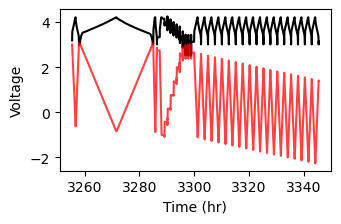

In [112]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, fit_sim_voltages, 'r', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

## Use a Unscented Kalman Filter (UKF) to Estimate Battery State
A online estimator updates estimates for the "state" of a system (here: the state of charge) each time a new measurement is available.
The UKF is one of many algorithms and a particularly useful one because it works with any model for the system performance

In [117]:
fit_asoh.mark_all_fixed()

In [118]:
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=fit_asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ECMTransientVector(soc=0.),
    covariance_joint=np.diag([0.1, 0.1])  # Two variables: soc and a hysteresis term we don't use
)

Let's test it first using the subset of cycles above

In [119]:
%%time
ukf_sim_voltages = np.zeros((len(initial_cycles),))
ukf_sim_soc = np.zeros_like(ukf_sim_voltages)
for j, (t, i, v) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'], initial_cycles['voltage'])):
    state, outputs = ukf.step(
        ECMInput(time=t, current=i, temperature=25),
        ECMMeasurement(terminal_voltage=v)
    )  # Moirae 
    ukf_sim_voltages[j] = outputs.get_mean().item()
    ukf_sim_soc[j] = state.get_mean()[0]

CPU times: user 2.57 s, sys: 4.97 ms, total: 2.57 s
Wall time: 2.57 s


Text(0, 0.5, 'Voltage')

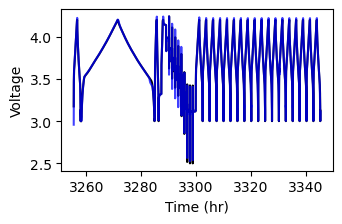

In [120]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, ukf_sim_voltages, 'b', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

The UKF adjusts the evolution of the model simulating the battery such it better matches observations.
In our case, it asjusting the estimated state of charge

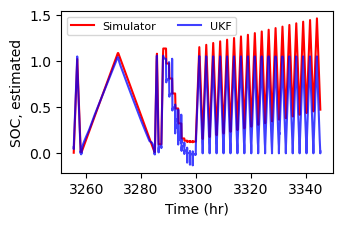

In [121]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, sim_soc, 'r', label='Simulator')
ax.plot(initial_cycles['test_time'] / 3600, ukf_sim_soc, 'b', alpha=0.75, label='UKF')

ax.set_xlabel('Time (hr)')
ax.set_ylabel('SOC, estimated')
ax.legend(ncols=2, fontsize=8)

Note how the simulator suggests that the state-of-charge of the battery must be far greater than one given the observed current.
The UKF, instead, reports that the SOC is closer to 1 given the observed current _and voltage_.

## Estimating Advanced State of Health
We don't need to assume that the parameters of the battery model state fixed over time.
Rather, we can treat the values of parameters as an Advanced State of Health metric and estimate how they evolve over time.

The first step in doing so with Moirae is to mark the health parameters as "updatable." We'll mark the theoretical capacity as one of those parameters

In [122]:
fit_asoh.mark_updatable('q_t.base_values')
fit_asoh.updatable_names

('q_t.base_values',)

There ~~are~~ will be numerous ways in Moirae to learn how the health parameters vary over time. 
A simple one is to treat them the same as any other state of the system, which we refer to as a "joint" estimation (hence the Joint in JointUnscentedKalmanFilter)

In [123]:
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=fit_asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ECMTransientVector(soc=0.),
    covariance_joint=np.diag([0.1, 0.1, 0.001])  # We add another parameter to account for the new variable
)

In [124]:
ukf.state_names

('soc', 'hyst', 'q_t.base_values')

Let's run with the entire dataset

In [125]:
%%time
states, _ = run_online_estimate(dataset, ukf, pbar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 110704/110705 [01:41<00:00, 1088.80it/s]

CPU times: user 1min 41s, sys: 421 ms, total: 1min 42s
Wall time: 1min 41s


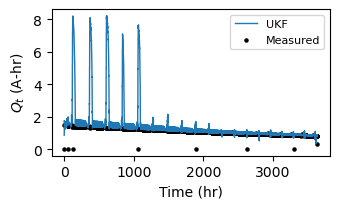

In [127]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.plot(dataset.raw_data['test_time'].iloc[1:] / 3600, states['q_t.base_values'], lw=1, label='UKF')
ax.scatter(dataset.cycle_stats['cycle_start'] / 3600, dataset.cycle_stats['capacity_charge'], color='k', s=5, label='Measured')

ax.legend(fontsize=8)
ax.set_ylabel('$Q_t$ (A-hr)')
ax.set_xlabel('Time (hr)')

fig.tight_layout()

It works, but the joint estimator leaves for improvement. The capacity parameter of the model ($Q_t$) changes over short timescales, which is unrealistic and something we'll improve upon in more advanced estimators.